In [88]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [89]:
%load_ext autoreload
%autoreload 2
from data.api_fetcher import ApiFetcher

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:

api = ApiFetcher(starting_year=2014, ending_year=2025)
df = api.get_dataframe(numeric=False, date=True, time_coeff=False, ids=True)



In [91]:
df1 = df.copy()
cols_to_drop = [col for col in ['home_team', 'away_team'] if col in df1.columns]
df1.drop(cols_to_drop, axis=1, inplace=True)


In [95]:
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import StandardScaler

    def prep_df(df1, target_cols=['home_pts', 'away_pts']):
        team_id_cols = ['home_team_id', 'away_team_id']
        exclude_cols = target_cols + team_id_cols + ['date', 'home_team', 'away_team']
        numeric_cols = [col for col in df1.columns if col not in exclude_cols]


        X_numeric_raw = df1[numeric_cols].values
        X_team_ids = df1[team_id_cols].astype(int).values
        y = df1[target_cols].values 

        scaler = StandardScaler()
        X_numeric = scaler.fit_transform(X_numeric_raw)

        return X_numeric, X_team_ids, y, scaler, numeric_cols
    X_numeric, X_team_ids, y, scaler, numeric_cols = prep_df(df)
    print("X_numeric shape:", X_numeric.shape)
    print("X_team_ids shape:", X_team_ids.shape)
    print("y shape:", y.shape)


X_numeric shape: (13203, 22)
X_team_ids shape: (13203, 2)
y shape: (13203, 2)


In [70]:
X_numeric, X_team_ids, y, scaler, numeric_cols = prep_df(df1)

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TeamEmbeddingNN(nn.Module):
    def __init__(self, num_teams, embedding_dim, num_numeric_features):
        super(TeamEmbeddingNN, self).__init__()
        
        # Embedding layers for home and away teams
        self.home_embedding = nn.Embedding(num_teams, embedding_dim)
        self.away_embedding = nn.Embedding(num_teams, embedding_dim)
        
        # Input layer size = numeric features + 2 embeddings concatenated
        input_size = num_numeric_features + embedding_dim * 2
        
        # Hidden layers
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        
        # Output layer (predict home_pts and away_pts)
        self.out = nn.Linear(32, 2)
        
    def forward(self, numeric_features, team_ids):
        
        home_emb = self.home_embedding(team_ids[:, 0])
        away_emb = self.away_embedding(team_ids[:, 1])
        
        # Concatenate embeddings with numeric features
        x = torch.cat([numeric_features, home_emb, away_emb], dim=1)
        
        # Forward pass through hidden layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output predicted points
        out = self.out(x)
        return out



Epoch 001 | Train MSE: 11355.8865 | Val MSE: 12296.4859 | LR: 0.000426
Epoch 002 | Train MSE: 8027.3746 | Val MSE: 4782.5626 | LR: 0.000505
Epoch 003 | Train MSE: 1594.4436 | Val MSE: 1002.6659 | LR: 0.000635
Epoch 004 | Train MSE: 572.2272 | Val MSE: 570.7740 | LR: 0.000815
Epoch 005 | Train MSE: 342.2829 | Val MSE: 376.0422 | LR: 0.001043
Epoch 006 | Train MSE: 213.6132 | Val MSE: 257.1485 | LR: 0.001317
Epoch 007 | Train MSE: 133.8230 | Val MSE: 179.5456 | LR: 0.001633
Epoch 008 | Train MSE: 82.1014 | Val MSE: 126.6241 | LR: 0.001989
Epoch 009 | Train MSE: 51.8893 | Val MSE: 102.7289 | LR: 0.002379
Epoch 010 | Train MSE: 36.4897 | Val MSE: 98.1486 | LR: 0.002801
Epoch 011 | Train MSE: 27.7819 | Val MSE: 89.0582 | LR: 0.003249
Epoch 012 | Train MSE: 22.7269 | Val MSE: 82.6513 | LR: 0.003718
Epoch 013 | Train MSE: 19.9872 | Val MSE: 76.2563 | LR: 0.004203
Epoch 014 | Train MSE: 18.6581 | Val MSE: 83.0539 | LR: 0.004700
Epoch 015 | Train MSE: 17.5066 | Val MSE: 66.3737 | LR: 0.005202
E

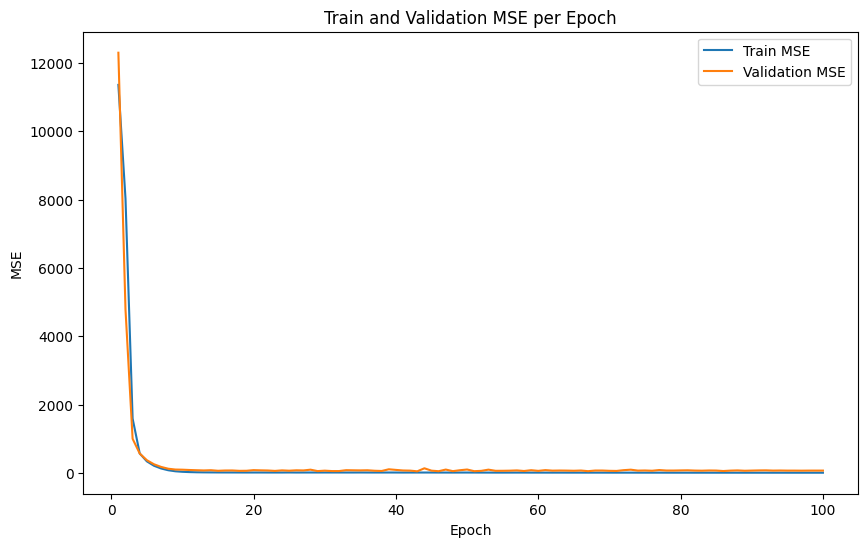

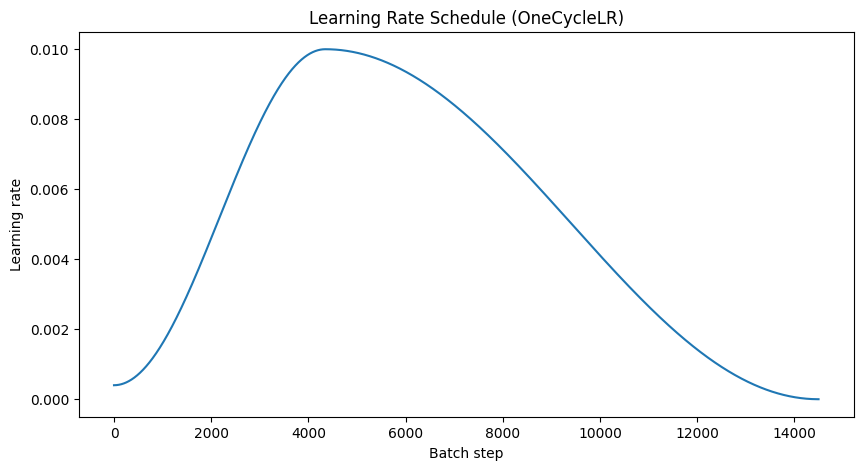

Test MSE: 57.2661


In [ ]:

#TEST - NIEISTOTNE NARAZIE 

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Chronological split ---
df_sorted = df1.sort_values('date')
n = len(df_sorted)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_df = df_sorted.iloc[:train_end]
val_df = df_sorted.iloc[train_end:val_end]
test_df = df_sorted.iloc[val_end:]

# --- 2. Preprocess splits ---
X_train_num, X_train_ids, y_train, scaler, numeric_cols = prep_df(train_df)
X_val_num, X_val_ids, y_val, _, _ = prep_df(val_df)
X_test_num, X_test_ids, y_test, _, _ = prep_df(test_df)

# --- 3. Dataset class ---
class NBAEmbeddingDataset(Dataset):
    def __init__(self, X_numeric, X_team_ids, y):
        self.X_numeric = torch.tensor(X_numeric, dtype=torch.float32)
        self.X_team_ids = torch.tensor(X_team_ids, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_numeric[idx], self.X_team_ids[idx], self.y[idx]

train_dataset = NBAEmbeddingDataset(X_train_num, X_train_ids, y_train)
val_dataset = NBAEmbeddingDataset(X_val_num, X_val_ids, y_val)
test_dataset = NBAEmbeddingDataset(X_test_num, X_test_ids, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- 4. Instantiate model ---
num_teams = df1['home_team_id'].nunique()
embedding_dim = 8
num_numeric_features = X_train_num.shape[1]

model = TeamEmbeddingNN(num_teams, embedding_dim, num_numeric_features)

# --- 5. Loss and optimizer ---
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- 6. OneCycleLR ---
steps_per_epoch = len(train_loader)
num_epochs = 100  # can be any number
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs
)

# --- 7. Training loop with early stopping & LR tracking ---
patience = 100
min_delta = 1e-4

train_losses = []
val_losses = []
lrs = []  # track learning rate

best_val_loss = np.inf
epochs_no_improve = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss_epoch = 0
    for X_num_batch, X_ids_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_num_batch, X_ids_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Track LR
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        
        train_loss_epoch += loss.item() * X_num_batch.size(0)
    train_loss_epoch /= len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    
    # Validation
    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for X_num_batch, X_ids_batch, y_batch in val_loader:
            outputs = model(X_num_batch, X_ids_batch)
            loss = criterion(outputs, y_batch)
            val_loss_epoch += loss.item() * X_num_batch.size(0)
    val_loss_epoch /= len(val_loader.dataset)
    val_losses.append(val_loss_epoch)
    
    print(f"Epoch {epoch+1:03d} | Train MSE: {train_loss_epoch:.4f} | Val MSE: {val_loss_epoch:.4f} | LR: {current_lr:.6f}")
    
    # Early stopping
    if val_loss_epoch + min_delta < best_val_loss:
        best_val_loss = val_loss_epoch
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# --- Load best model ---
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# --- 8. Plot MSE per actual epoch ---
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train MSE')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Train and Validation MSE per Epoch')
plt.legend()
plt.show()

# --- 9. Plot Learning Rate schedule ---
plt.figure(figsize=(10,5))
plt.plot(lrs)
plt.xlabel('Batch step')
plt.ylabel('Learning rate')
plt.title('Learning Rate Schedule (OneCycleLR)')
plt.show()

# --- 10. Evaluate on test set ---
model.eval()
test_loss = 0
with torch.no_grad():
    for X_num_batch, X_ids_batch, y_batch in test_loader:
        outputs = model(X_num_batch, X_ids_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_num_batch.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test MSE: {test_loss:.4f}")

# --- 11. Extract embeddings ---
home_vectors = model.home_embedding.weight.data.cpu().numpy()
away_vectors = model.away_embedding.weight.data.cpu().numpy()


Epoch 1/250 | Train MSE: 1752.7888 | Val MSE: 183.1412
Epoch 2/250 | Train MSE: 62.0947 | Val MSE: 104.9688
Epoch 3/250 | Train MSE: 26.3272 | Val MSE: 77.3303
Epoch 4/250 | Train MSE: 18.8468 | Val MSE: 70.3591
Epoch 5/250 | Train MSE: 16.8049 | Val MSE: 77.8436
Epoch 6/250 | Train MSE: 16.0225 | Val MSE: 70.2036
Epoch 7/250 | Train MSE: 15.5087 | Val MSE: 72.1405
Epoch 8/250 | Train MSE: 15.4092 | Val MSE: 58.7549
Epoch 9/250 | Train MSE: 15.0682 | Val MSE: 79.5961
Epoch 10/250 | Train MSE: 15.3424 | Val MSE: 66.8765
Epoch 11/250 | Train MSE: 14.5396 | Val MSE: 82.3148
Epoch 12/250 | Train MSE: 15.6475 | Val MSE: 60.6217
Epoch 13/250 | Train MSE: 15.1461 | Val MSE: 85.6100
Epoch 14/250 | Train MSE: 14.7901 | Val MSE: 84.0041
Epoch 15/250 | Train MSE: 15.1452 | Val MSE: 93.4916
Epoch 16/250 | Train MSE: 14.9824 | Val MSE: 57.5532
Epoch 17/250 | Train MSE: 16.5621 | Val MSE: 65.6158
Epoch 18/250 | Train MSE: 15.3723 | Val MSE: 84.0878
Epoch 19/250 | Train MSE: 14.6158 | Val MSE: 66.517

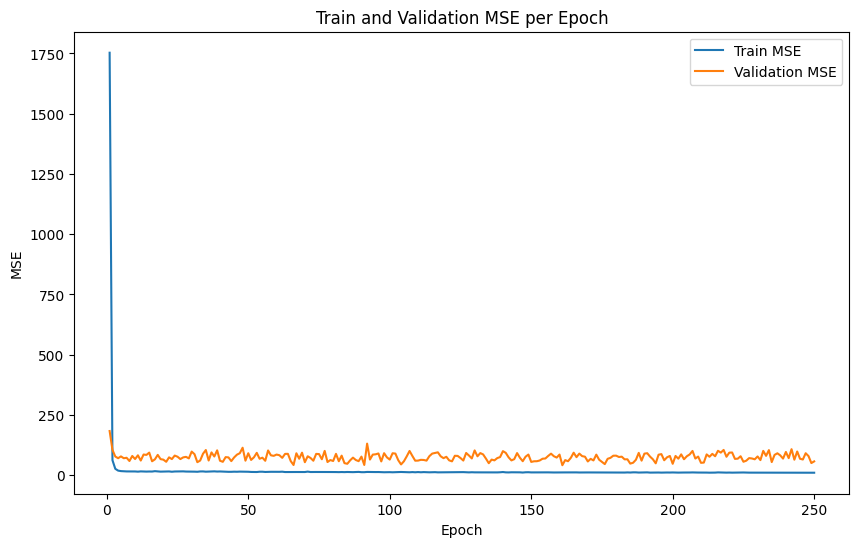

Test MSE: 45.6435


In [117]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Chronological split ---
df_sorted = df1.sort_values('date')
n = len(df_sorted)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_df = df_sorted.iloc[:train_end]
val_df = df_sorted.iloc[train_end:val_end]
test_df = df_sorted.iloc[val_end:]

# --- 2. Preprocess splits ---
X_train_num, X_train_ids, y_train, scaler, numeric_cols = prep_df(train_df)
X_val_num, X_val_ids, y_val, _, _ = prep_df(val_df)
X_test_num, X_test_ids, y_test, _, _ = prep_df(test_df)

# --- 3. Dataset class ---
class NBAEmbeddingDataset(Dataset):
    def __init__(self, X_numeric, X_team_ids, y):
        self.X_numeric = torch.tensor(X_numeric, dtype=torch.float32)
        self.X_team_ids = torch.tensor(X_team_ids, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_numeric[idx], self.X_team_ids[idx], self.y[idx]

train_dataset = NBAEmbeddingDataset(X_train_num, X_train_ids, y_train)
val_dataset = NBAEmbeddingDataset(X_val_num, X_val_ids, y_val)
test_dataset = NBAEmbeddingDataset(X_test_num, X_test_ids, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- 4. Instantiate model ---
num_teams = df1['home_team_id'].nunique()
embedding_dim = 8
num_numeric_features = X_train_num.shape[1]

model = TeamEmbeddingNN(num_teams, embedding_dim, num_numeric_features)

# --- 5. Loss and optimizer ---
criterion = nn.MSELoss()
learning_rate = 0.009187
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- 6. Training loop (fixed epochs) ---
num_epochs = 250

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss_epoch = 0
    for X_num_batch, X_ids_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_num_batch, X_ids_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * X_num_batch.size(0)
    train_loss_epoch /= len(train_loader.dataset)
    train_losses.append(train_loss_epoch)

    # Validation
    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for X_num_batch, X_ids_batch, y_batch in val_loader:
            outputs = model(X_num_batch, X_ids_batch)
            loss = criterion(outputs, y_batch)
            val_loss_epoch += loss.item() * X_num_batch.size(0)
    val_loss_epoch /= len(val_loader.dataset)
    val_losses.append(val_loss_epoch)

    print(f"Epoch {epoch+1}/{num_epochs} | Train MSE: {train_loss_epoch:.4f} | Val MSE: {val_loss_epoch:.4f}")

# --- 7. Plot MSE ---
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train MSE')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Train and Validation MSE per Epoch')
plt.legend()
plt.show()

# --- 8. Evaluate on test set ---
model.eval()
test_loss = 0
with torch.no_grad():
    for X_num_batch, X_ids_batch, y_batch in test_loader:
        outputs = model(X_num_batch, X_ids_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_num_batch.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test MSE: {test_loss:.4f}")

# --- 9. Extract embeddings ---
home_vectors = model.home_embedding.weight.data.cpu().numpy()
away_vectors = model.away_embedding.weight.data.cpu().numpy()
